In [1]:
import pandas as pd

# 데이터 불러오기
b_df = pd.read_csv('./datasets/bank.csv')

# 데이터 복사
pre_b_df = b_df.copy()

# 불필요한 컬럼 삭제하기
pre_b_df = pre_b_df.drop(labels=['id', 'CustomerId'], axis=1).reset_index(drop=True)

# 타겟 데이터 설정하기
pre_b_df['target'] = pre_b_df['Exited']
pre_b_df = pre_b_df.drop(labels=['Exited'], axis=1)

# 타겟 데이터 비중 동일하게 조정 (언더샘플링)
zero = pre_b_df[pre_b_df.target == 0].sample(34921, random_state=124)
one = pre_b_df[pre_b_df.target == 1]

pre_b_df = pd.concat([zero, one])
pre_b_df.reset_index(drop=True, inplace=True)

In [2]:
from sklearn.preprocessing import LabelEncoder

# 문자열 컬럼 추출
columns = ['Surname', 'Geography', 'Gender']
label_encoders = {}

# 컬럼 반복하여 column에 담아 적용:
for column in columns:
    # LabelEncoder 객체 생성, 문자열 데이터 인코딩을 통해 정수로 형변환 후 데이터 교체
    encoder = LabelEncoder()
    # LabelEncoder를 사용하여 각 컬럼의 값을 변환
    result = encoder.fit_transform(pre_b_df[column])
    # 변환된 값의 클래스(고유한 값) 저장
    label_encoders[column] = encoder.classes_
    # 변환된 값 적용
    pre_b_df[column] = result

In [3]:
# 상관 관계가 낮은 피처 제거
pre_b_df = pre_b_df.drop(labels=['CreditScore'], axis=1)

In [4]:
pre_b4_df = pre_b_df.copy()

In [5]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

features, targets = pre_b4_df.iloc[:, :-1], pre_b4_df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(features, targets, stratify=targets, test_size=0.2, random_state=124)

smote = SMOTE(random_state=124)
over_X_train, over_y_train = smote.fit_resample(X_train, y_train)

In [6]:
train_df = pd.concat([over_X_train, over_y_train], axis=1).reset_index(drop=True)
test_df = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

In [7]:
train_df.target.value_counts()

target
1    27937
0    27937
Name: count, dtype: int64

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=1)

lda_train = lda.fit_transform(train_df.iloc[:, :-1], train_df.iloc[:, -1])
lda_test = lda.fit_transform(test_df.iloc[:, :-1], test_df.iloc[:, -1])

print(lda_train.shape, lda_test.shape)

(55874, 1) (13969, 1)


In [9]:
lda_columns = [f'lda{i+1}' for i in range(lda_train.shape[1])]
lda_train_df = pd.DataFrame(lda_train, columns=lda_columns)
lda_train_df.loc[:, 'target'] = train_df['target']

lda_columns = [f'lda{i+1}' for i in range(lda_test.shape[1])]
lda_test_df = pd.DataFrame(lda_test, columns=lda_columns)
lda_test_df.loc[:, 'target'] = test_df['target']

display(lda_train_df)

,lda1,target
0,-1.621804,1
1,-2.196557,1
2,0.118258,0
3,-1.430502,1
4,2.044428,0
...,...,...
55869,0.791961,0
55870,-0.225881,1
55871,0.910286,0
55872,-1.303382,0


In [10]:
print(lda.explained_variance_ratio_.sum())

1.0


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

X_train, y_train = lda_train_df.iloc[:, :-1], lda_train_df.iloc[:, -1]
X_test, y_test = lda_test_df.iloc[:, :-1], lda_test_df.iloc[:, -1]

# 객체 생성
# penalty: 규제 유형 (l2 = L2 규제)
lg = LogisticRegression(solver='liblinear', penalty='l2', random_state=124)

# 훈련
lg.fit(X_train, y_train)

# 예측
prediction = lg.predict(X_test)

In [12]:
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score
import matplotlib.pyplot as plt

def get_evaluation(y_test, prediction, classifier=None, X_test=None):
    confusion = confusion_matrix(y_test, prediction)
    accuracy = accuracy_score(y_test , prediction)
    precision = precision_score(y_test , prediction)
    recall = recall_score(y_test , prediction)
    f1 = f1_score(y_test, prediction)
    roc_auc = roc_auc_score(y_test, prediction)

    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy , precision ,recall, f1, roc_auc))
    print("#" * 75)
    
    if classifier is not None and  X_test is not None:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
        titles_options = [("Confusion matrix", None), ("Normalized confusion matrix", "true")]

        for (title, normalize), ax in zip(titles_options, axes.flatten()):
            disp = ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test, ax=ax, cmap=plt.cm.Blues, normalize=normalize)
            disp.ax_.set_title(title)
        plt.show()

오차 행렬
[[5192 1793]
 [1907 5077]]
정확도: 0.7351, 정밀도: 0.7390, 재현율: 0.7269, F1:0.7329, AUC:0.7351
###########################################################################


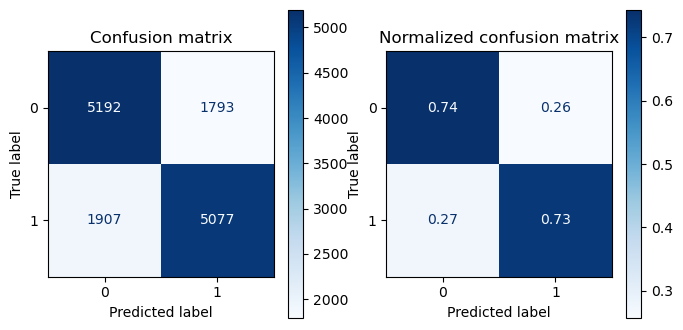

In [13]:
get_evaluation(y_test, prediction, lg, X_test)

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()

parameters = {
    'max_depth': [5, 6, 7],
    'min_samples_split': [7, 8, 9]
}

g_dtc = GridSearchCV(dtc, param_grid=parameters, cv=5, refit=True, return_train_score=True, n_jobs=-1)
g_dtc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7],
                         'min_samples_split': [7, 8, 9]},
             return_train_score=True)

In [15]:
dtc_result_df = pd.DataFrame(g_dtc.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]
display(dtc_result_df)

,params,mean_test_score,rank_test_score
0,"{'max_depth': 5, 'min_samples_split': 7}",0.736067,1
1,"{'max_depth': 5, 'min_samples_split': 8}",0.736067,1
2,"{'max_depth': 5, 'min_samples_split': 9}",0.736067,1
3,"{'max_depth': 6, 'min_samples_split': 7}",0.735781,4
4,"{'max_depth': 6, 'min_samples_split': 8}",0.735781,4
5,"{'max_depth': 6, 'min_samples_split': 9}",0.735763,6
6,"{'max_depth': 7, 'min_samples_split': 7}",0.734921,7
7,"{'max_depth': 7, 'min_samples_split': 8}",0.734904,8
8,"{'max_depth': 7, 'min_samples_split': 9}",0.734904,8


오차 행렬
[[5279 1706]
 [1979 5005]]
정확도: 0.7362, 정밀도: 0.7458, 재현율: 0.7166, F1:0.7309, AUC:0.7362
###########################################################################


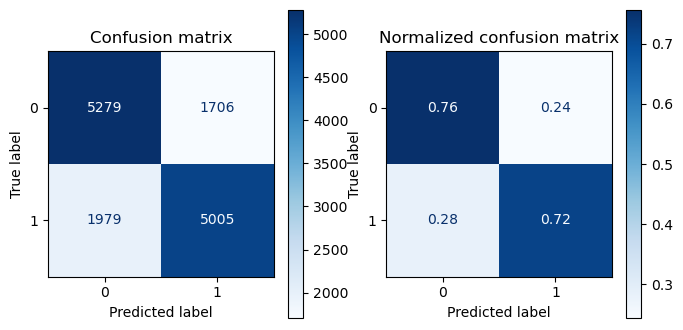

In [16]:
dtc = g_dtc.best_estimator_
dtc_prediction = dtc.predict(X_test)
get_evaluation(y_test, dtc_prediction, dtc, X_test)

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()

parameters = {
    'max_depth': [5, 6, 7],
    'min_samples_split': [7, 8, 9]
}

g_dtc = GridSearchCV(dtc, param_grid=parameters, cv=5, refit=True, return_train_score=True, n_jobs=-1)
g_dtc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7],
                         'min_samples_split': [7, 8, 9]},
             return_train_score=True)

In [18]:
dtc_result_df = pd.DataFrame(g_dtc.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]
display(dtc_result_df)

,params,mean_test_score,rank_test_score
0,"{'max_depth': 5, 'min_samples_split': 7}",0.736067,1
1,"{'max_depth': 5, 'min_samples_split': 8}",0.736067,1
2,"{'max_depth': 5, 'min_samples_split': 9}",0.736067,1
3,"{'max_depth': 6, 'min_samples_split': 7}",0.735781,4
4,"{'max_depth': 6, 'min_samples_split': 8}",0.735781,4
5,"{'max_depth': 6, 'min_samples_split': 9}",0.735763,6
6,"{'max_depth': 7, 'min_samples_split': 7}",0.734921,7
7,"{'max_depth': 7, 'min_samples_split': 8}",0.734904,8
8,"{'max_depth': 7, 'min_samples_split': 9}",0.734904,8


오차 행렬
[[5279 1706]
 [1979 5005]]
정확도: 0.7362, 정밀도: 0.7458, 재현율: 0.7166, F1:0.7309, AUC:0.7362
###########################################################################


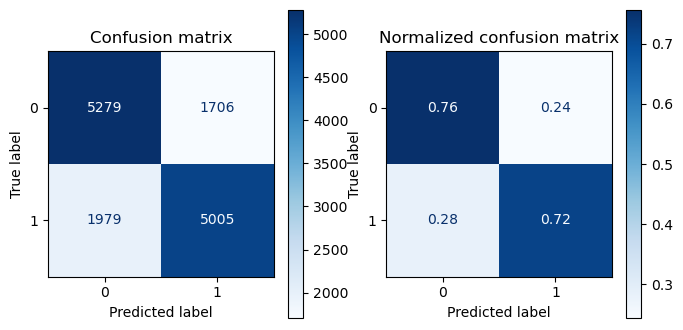

In [19]:
dtc = g_dtc.best_estimator_
dtc_prediction = dtc.predict(X_test)
get_evaluation(y_test, dtc_prediction, dtc, X_test)

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

svc_parameters = {
    'C': [0.001, 0.01, 0.1],
    'gamma': [0.001, 0.01, 0.1],
    'kernel': ['linear', 'rbf']
}

l_svc_parameters = {'C': [0.001, 0.01, 0.1]}

svc = SVC(probability=True, verbose=2)
l_svc = LinearSVC(verbose=True)

g_svc = GridSearchCV(l_svc, param_grid=l_svc_parameters, cv=5, refit=True, return_train_score=True, n_jobs=-1)
g_svc.fit(X_train, y_train)

[LibLinear]

GridSearchCV(cv=5, estimator=LinearSVC(verbose=True), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1]}, return_train_score=True)

In [21]:
svc_result_df = pd.DataFrame(g_svc.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]
display(svc_result_df)

,params,mean_test_score,rank_test_score
0,{'C': 0.001},0.737427,1
1,{'C': 0.01},0.737391,2
2,{'C': 0.1},0.737391,2


오차 행렬
[[5194 1791]
 [1918 5066]]
정확도: 0.7345, 정밀도: 0.7388, 재현율: 0.7254, F1:0.7320, AUC:0.7345
###########################################################################


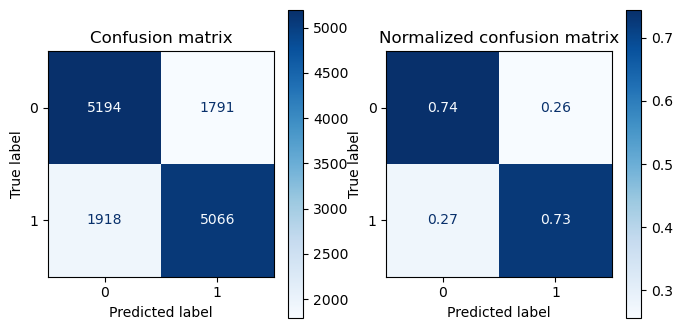

In [22]:
svc = g_svc.best_estimator_
svc_prediction = svc.predict(X_test)
get_evaluation(y_test, svc_prediction, svc, X_test)

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

knn_parameters = {
    'n_neighbors': [1, 3, 5, 7, 9]
}

g_knn = GridSearchCV(knn, param_grid=knn_parameters, cv=5, refit=True, return_train_score=True, n_jobs=-1)
g_knn.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9]},
             return_train_score=True)

In [24]:
knn_result_df = pd.DataFrame(g_knn.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]
display(knn_result_df)

,params,mean_test_score,rank_test_score
0,{'n_neighbors': 1},0.646598,5
1,{'n_neighbors': 3},0.683037,4
2,{'n_neighbors': 5},0.700791,3
3,{'n_neighbors': 7},0.710438,2
4,{'n_neighbors': 9},0.715897,1


오차 행렬
[[5092 1893]
 [2123 4861]]
정확도: 0.7125, 정밀도: 0.7197, 재현율: 0.6960, F1:0.7077, AUC:0.7125
###########################################################################


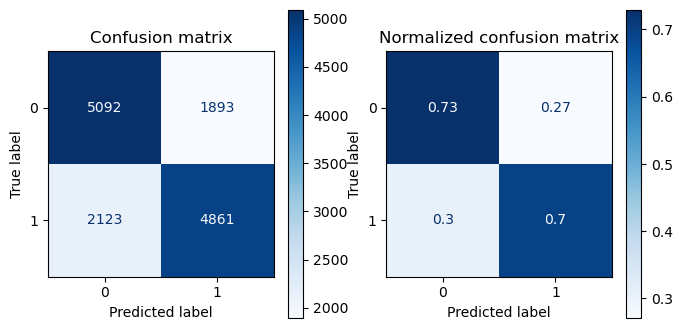

In [25]:
knn = g_knn.best_estimator_
knn_prediction = knn.predict(X_test)
get_evaluation(y_test, knn_prediction, knn, X_test)

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rfc_parameters = {
    'max_depth': [10, 11, 12],
    'min_samples_split': [10, 11, 12],
    'n_estimators': [10, 50, 100, 500, 1000]
}

rfc = RandomForestClassifier(n_estimators=50)

g_rfc = GridSearchCV(rfc, param_grid=rfc_parameters, cv=5, refit=True, return_train_score=True, n_jobs=-1)

g_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_estimators=50), n_jobs=-1,
             param_grid={'max_depth': [10, 11, 12],
                         'min_samples_split': [10, 11, 12],
                         'n_estimators': [10, 50, 100, 500, 1000]},
             return_train_score=True)

In [27]:
rfc_result_df = pd.DataFrame(g_rfc.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]
display(rfc_result_df)

,params,mean_test_score,rank_test_score
0,"{'max_depth': 10, 'min_samples_split': 10, 'n_...",0.734367,40
1,"{'max_depth': 10, 'min_samples_split': 10, 'n_...",0.735441,17
2,"{'max_depth': 10, 'min_samples_split': 10, 'n_...",0.735333,23
3,"{'max_depth': 10, 'min_samples_split': 10, 'n_...",0.735709,10
4,"{'max_depth': 10, 'min_samples_split': 10, 'n_...",0.735798,7
5,"{'max_depth': 10, 'min_samples_split': 11, 'n_...",0.735226,26
6,"{'max_depth': 10, 'min_samples_split': 11, 'n_...",0.736461,1
7,"{'max_depth': 10, 'min_samples_split': 11, 'n_...",0.735781,8
8,"{'max_depth': 10, 'min_samples_split': 11, 'n_...",0.735548,13
9,"{'max_depth': 10, 'min_samples_split': 11, 'n_...",0.735369,21


오차 행렬
[[5341 1644]
 [2064 4920]]
정확도: 0.7346, 정밀도: 0.7495, 재현율: 0.7045, F1:0.7263, AUC:0.7346
###########################################################################


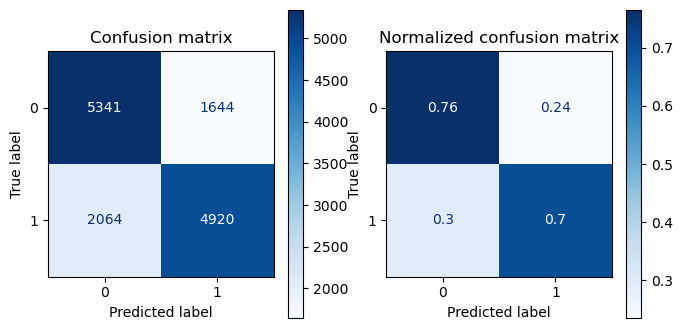

In [28]:
rfc = g_rfc.best_estimator_
rfc_prediction = rfc.predict(X_test)
get_evaluation(y_test, rfc_prediction, rfc, X_test)

In [29]:
from sklearn.ensemble import VotingClassifier

hard_vc = VotingClassifier(estimators=[
    ('dtc', dtc), ('l_svc', l_svc), ('knn', knn)
], voting='hard', n_jobs=-1)

hard_vc.fit(X_train, y_train)

VotingClassifier(estimators=[('dtc',
                              DecisionTreeClassifier(max_depth=5,
                                                     min_samples_split=7)),
                             ('l_svc', LinearSVC(verbose=True)),
                             ('knn', KNeighborsClassifier(n_neighbors=9))],
                 n_jobs=-1)

오차 행렬
[[5251 1734]
 [1954 5030]]
정확도: 0.7360, 정밀도: 0.7436, 재현율: 0.7202, F1:0.7317, AUC:0.7360
###########################################################################


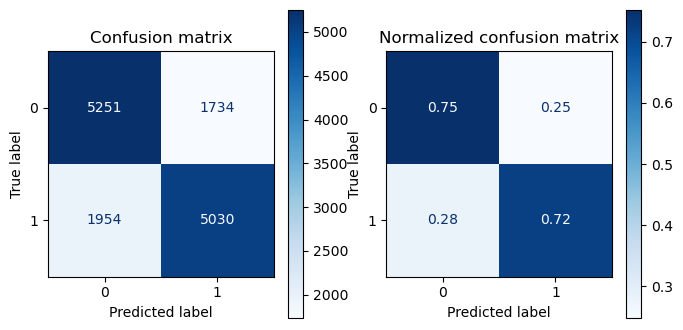

In [30]:
hard_vc_prediction = hard_vc.predict(X_test)
get_evaluation(y_test, hard_vc_prediction, hard_vc, X_test)

In [31]:
from sklearn.ensemble import VotingClassifier

soft_vc = VotingClassifier(estimators=[
    ('dtc', dtc), ('l_svc', l_svc), ('knn', knn)
], voting='soft', n_jobs=-1)

soft_vc.fit(X_train, y_train)

VotingClassifier(estimators=[('dtc',
                              DecisionTreeClassifier(max_depth=5,
                                                     min_samples_split=7)),
                             ('l_svc', LinearSVC(verbose=True)),
                             ('knn', KNeighborsClassifier(n_neighbors=9))],
                 n_jobs=-1, voting='soft')

In [ ]:
soft_vc_prediction = soft_vc.predict(X_test)
get_evaluation(y_test, soft_vc_prediction, soft_vc, X_test)

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

ada_parameters = {
    'n_estimators': [50, 100, 500],
    'learning_rate': [0.3, 0.5, 0.7, 1]
}

g_ada = GridSearchCV(AdaBoostClassifier(), param_grid=ada_parameters, cv=5, refit=True, return_train_score=True, n_jobs=-1)
g_ada.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.3, 0.5, 0.7, 1],
                         'n_estimators': [50, 100, 500]},
             return_train_score=True)

In [34]:
ada_result_df = pd.DataFrame(g_ada.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]
display(ada_result_df)

,params,mean_test_score,rank_test_score
0,"{'learning_rate': 0.3, 'n_estimators': 50}",0.736604,8
1,"{'learning_rate': 0.3, 'n_estimators': 100}",0.736604,8
2,"{'learning_rate': 0.3, 'n_estimators': 500}",0.736622,5
3,"{'learning_rate': 0.5, 'n_estimators': 50}",0.736604,8
4,"{'learning_rate': 0.5, 'n_estimators': 100}",0.736622,3
5,"{'learning_rate': 0.5, 'n_estimators': 500}",0.736640,1
6,"{'learning_rate': 0.7, 'n_estimators': 50}",0.736604,8
7,"{'learning_rate': 0.7, 'n_estimators': 100}",0.736640,1
8,"{'learning_rate': 0.7, 'n_estimators': 500}",0.736604,7
9,"{'learning_rate': 1, 'n_estimators': 50}",0.736622,5


오차 행렬
[[5426 1559]
 [2167 4817]]
정확도: 0.7333, 정밀도: 0.7555, 재현율: 0.6897, F1:0.7211, AUC:0.7333
###########################################################################


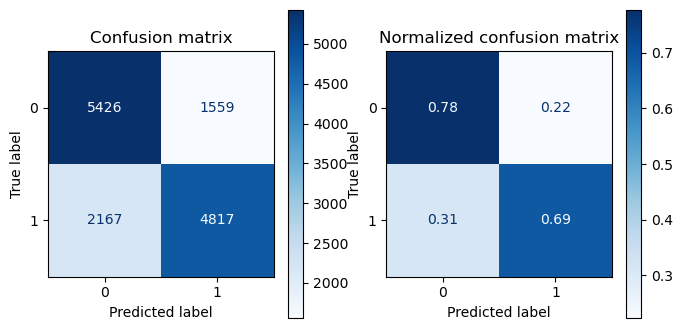

In [35]:
ada = g_ada.best_estimator_
ada_prediction = ada.predict(X_test)
get_evaluation(y_test, ada_prediction, ada, X_test)

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

gbm_parameters = {
    'n_estimators': [50, 100, 500],
    'learning_rate': [0.3, 0.5, 0.7, 1]
}

g_gbc = GridSearchCV(GradientBoostingClassifier(loss='log_loss'), param_grid=gbm_parameters, cv=5, refit=True, return_train_score=True, n_jobs=-1)
g_gbc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.3, 0.5, 0.7, 1],
                         'n_estimators': [50, 100, 500]},
             return_train_score=True)

In [37]:
gbc_result_df = pd.DataFrame(g_gbc.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]
display(gbc_result_df)

,params,mean_test_score,rank_test_score
0,"{'learning_rate': 0.3, 'n_estimators': 50}",0.735834,1
1,"{'learning_rate': 0.3, 'n_estimators': 100}",0.734098,3
2,"{'learning_rate': 0.3, 'n_estimators': 500}",0.721212,9
3,"{'learning_rate': 0.5, 'n_estimators': 50}",0.734420,2
4,"{'learning_rate': 0.5, 'n_estimators': 100}",0.732040,6
5,"{'learning_rate': 0.5, 'n_estimators': 500}",0.715163,10
6,"{'learning_rate': 0.7, 'n_estimators': 50}",0.733257,4
7,"{'learning_rate': 0.7, 'n_estimators': 100}",0.729212,7
8,"{'learning_rate': 0.7, 'n_estimators': 500}",0.709597,11
9,"{'learning_rate': 1, 'n_estimators': 50}",0.732613,5


오차 행렬
[[5268 1717]
 [1986 4998]]
정확도: 0.7349, 정밀도: 0.7443, 재현율: 0.7156, F1:0.7297, AUC:0.7349
###########################################################################


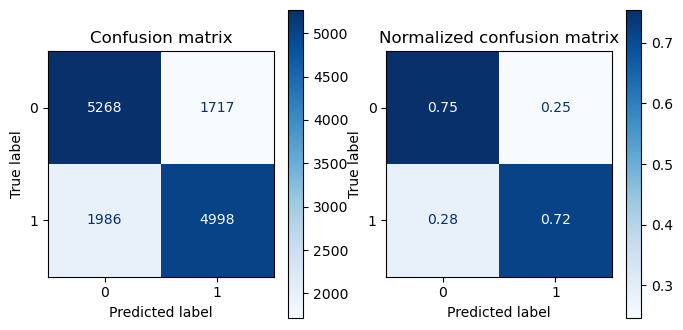

In [38]:
gbc = g_gbc.best_estimator_
gbc_prediction = gbc.predict(X_test)
get_evaluation(y_test, gbc_prediction, gbc, X_test)

In [39]:
from xgboost import XGBClassifier

X_val_train, X_val_test, y_val_train, y_val_test = \
train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=124)

evals = [(X_val_train, y_val_train), (X_val_test, y_val_test)]

In [42]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'n_estimators': [50, 100, 500],
    'learning_rate': [0.3, 0.5, 0.7, 1]
}

xgb = XGBClassifier()

g_xgb = GridSearchCV(xgb, 
                     param_grid=parameters, 
                     cv=5, 
                     refit=True, 
                     return_train_score=True, 
                     n_jobs=-1)

g_xgb.fit(X_train, y_train, early_stopping_rounds=50, eval_set=evals)

C:\ProgramData\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.61988	validation_1-logloss:0.61877
[1]	validation_0-logloss:0.58184	validation_1-logloss:0.58011
[2]	validation_0-logloss:0.56091	validation_1-logloss:0.55866
[3]	validation_0-logloss:0.54912	validation_1-logloss:0.54658
[4]	validation_0-logloss:0.54249	validation_1-logloss:0.53983
[5]	validation_0-logloss:0.53878	validation_1-logloss:0.53602
[6]	validation_0-logloss:0.53669	validation_1-logloss:0.53396
[7]	validation_0-logloss:0.53554	validation_1-logloss:0.53278
[8]	validation_0-logloss:0.53492	validation_1-logloss:0.53207
[9]	validation_0-logloss:0.53455	validation_1-logloss:0.53171
[10]	validation_0-logloss:0.53434	validation_1-logloss:0.53150
[11]	validation_0-logloss:0.53421	validation_1-logloss:0.53139
[12]	validation_0-logloss:0.53414	validation_1-logloss:0.53132
[13]	validation_0-logloss:0.53408	validation_1-logloss:0.53129
[14]	validation_0-logloss:0.53404	validation_1-logloss:0.53126
[15]	validation_0-logloss:0.53402	validation_1-logloss:0.53123
[1

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.3, 0.5, 0.7, 1],
                         'n_estimators': [50, 100, 500]},
             return_train_score=True)

In [43]:
result_df = pd.DataFrame(g_xgb.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]
display(result_df)

,params,mean_test_score,rank_test_score
0,"{'learning_rate': 0.3, 'n_estimators': 50}",0.736138,1
1,"{'learning_rate': 0.3, 'n_estimators': 100}",0.736049,2
2,"{'learning_rate': 0.3, 'n_estimators': 500}",0.736049,2
3,"{'learning_rate': 0.5, 'n_estimators': 50}",0.736013,4
4,"{'learning_rate': 0.5, 'n_estimators': 100}",0.735763,8
5,"{'learning_rate': 0.5, 'n_estimators': 500}",0.735763,8
6,"{'learning_rate': 0.7, 'n_estimators': 50}",0.735619,10
7,"{'learning_rate': 0.7, 'n_estimators': 100}",0.735619,10
8,"{'learning_rate': 0.7, 'n_estimators': 500}",0.735619,10
9,"{'learning_rate': 1, 'n_estimators': 50}",0.735960,5


In [44]:
xgb = g_xgb.best_estimator_
xgb_prediction = xgb.predict(X_test)

오차 행렬
[[5325 1660]
 [2049 4935]]
정확도: 0.7345, 정밀도: 0.7483, 재현율: 0.7066, F1:0.7269, AUC:0.7345
###########################################################################


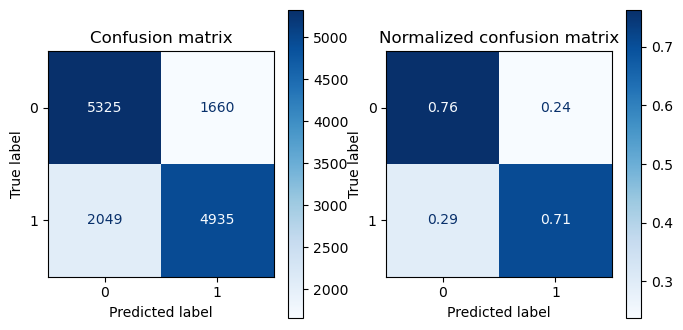

In [45]:
get_evaluation(y_test, xgb_prediction, xgb, X_test)

In [47]:
from lightgbm import LGBMClassifier

parameters = {
    'n_estimators': [50, 100, 500],
    'learning_rate': [0.3, 0.5, 0.7, 1]
}

X_val_train, X_val_test, y_val_train, y_val_test = \
train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=124)

evals = [(X_val_train, y_val_train), (X_val_test, y_val_test)]

g_lgbm = GridSearchCV(LGBMClassifier(), param_grid=parameters, cv=5, refit=True, return_train_score=True, n_jobs=-1)
g_lgbm.fit(X_train, y_train, eval_set=evals)

[LightGBM] [Info] Number of positive: 27937, number of negative: 27937
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 55874, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.3, 0.5, 0.7, 1],
                         'n_estimators': [50, 100, 500]},
             return_train_score=True)

In [48]:
result_df = pd.DataFrame(g_lgbm.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]
display(result_df)

,params,mean_test_score,rank_test_score
0,"{'learning_rate': 0.3, 'n_estimators': 50}",0.735136,7
1,"{'learning_rate': 0.3, 'n_estimators': 100}",0.735136,7
2,"{'learning_rate': 0.3, 'n_estimators': 500}",0.735226,1
3,"{'learning_rate': 0.5, 'n_estimators': 50}",0.735136,7
4,"{'learning_rate': 0.5, 'n_estimators': 100}",0.735136,7
5,"{'learning_rate': 0.5, 'n_estimators': 500}",0.735226,1
6,"{'learning_rate': 0.7, 'n_estimators': 50}",0.735136,7
7,"{'learning_rate': 0.7, 'n_estimators': 100}",0.735136,7
8,"{'learning_rate': 0.7, 'n_estimators': 500}",0.735226,1
9,"{'learning_rate': 1, 'n_estimators': 50}",0.735226,1


In [49]:
lgbm = g_lgbm.best_estimator_

lgbm_prediction = lgbm.predict(X_test)

오차 행렬
[[5267 1718]
 [2006 4978]]
정확도: 0.7334, 정밀도: 0.7434, 재현율: 0.7128, F1:0.7278, AUC:0.7334
###########################################################################


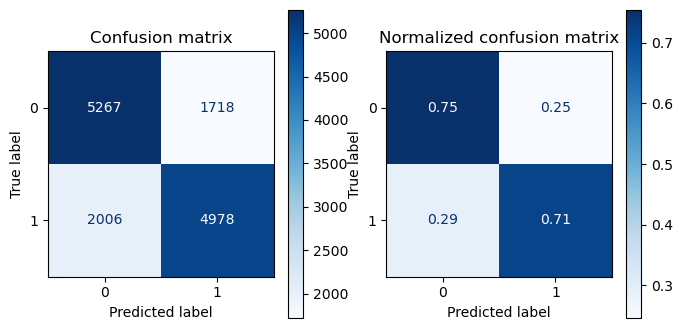

In [50]:
get_evaluation(y_test, lgbm_prediction, lgbm, X_test)

해당 모델은 은행 고객의 이탈을 예측하는 모델이다(0: 유지, 1: 탈퇴).

TP: 이탈할 고객을 이탈할 고객으로 올바르게 분류한 경우
FP: 이탈하지 않을 고객을 이탈할 고객으로 잘못 분류한 경우
TN: 이탈하지 않을 고객을 이탈하지 않을 고객으로 올바르게 분류한 경우
FN: 이탈할 고객을 이탈하지 않을 고객으로 잘못 분류한 경우

정밀도: 이탈할 고객으로 예측한 고객중에서 실제로 이탈한 고객의 비율을 나타낸다.
즉, 음성으로 예측한 결과중 얼마나 많은것이 음성인지 측정한다.

재현율: 실제로 이탈한 고객중에서 이탈 고객으로 정확하게 예측한 고객의 비율을 나타낸다.
즉, 얼마나 많은 고객을 놓치지않고 감지했는지 측정한다.

해당 모델은 이탈 고객을 예측하여 이탈을 방지하는 목적으로 만들어지는 모델이라고 가정할 때,
모델이 이탈할 고객을 이탈하지 않을 고객으로 잘못 분류하여 놓치는 경우(FN) 은행의 고객 유지에 좋지 않다.
때문에 FN을 낮추기 위해 임계치를 낮추고 재현율을 올려주는 것이 적절하다고 판단한다.

In [51]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def precision_recall_curve_plot(y_test , proba_class1):

    precisions, recalls, thresholds = precision_recall_curve(y_test, proba_class1)
    
    # X축: threshold
    # Y축: 정밀도, 재현율 시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # X축(threshold)의 Scale을 0 ~ 1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

In [52]:
from sklearn.metrics import roc_curve

def roc_curve_plot(y_test , proba_class1):
#     임계값에 따른 FPR, TPR 값
    fprs, tprs, thresholds = roc_curve(y_test, proba_class1)

#     ROC Curve를 plot 곡선으로 그림. 
    plt.plot(fprs , tprs, label='ROC')
#     가운데 대각선 직선을 그림. 
#     TPR과 FPR이 동일한 비율로 떨어진다는 것은 모델이 양성과 음성을 구별하지 못한다는 것을 의미한다.
#     다른 분류기를 판단하기 위한 기준선으로 사용되며, 
#     대각선에 가까울 수록 예측에 사용하기 힘든 모델이라는 뜻이다.
    plt.plot([0, 1], [0, 1], 'k--', label='Standard')
    
    # X축(FPR)의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()

In [53]:
from sklearn.preprocessing import Binarizer
# thresholds = [0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59]

# threshold를 입력하여 입력받은 각각의 threshold를 binarizer를 통해 예측 확률을 만들어냅니다
def get_evaluation_by_thresholds(y_test, proba_class1, thresholds):
    for threshold in thresholds:
        print(threshold)
        binarizer = Binarizer(threshold=threshold).fit(proba_class1)
        custom_prediction = binarizer.transform(proba_class1)
        get_evaluation(y_test, custom_prediction)

In [55]:
proba_class1 = lg.predict_proba(X_test)[:, 1].reshape(-1, 1)
_, _, thresholds = precision_recall_curve(y_test, proba_class1)
thresholds

array([0.02022873, 0.02174216, 0.02285446, ..., 0.99072567, 0.99350561,
       0.99444886])

In [56]:
get_evaluation_by_thresholds(y_test, proba_class1, thresholds)

0.020228725252007376
오차 행렬
[[   1 6984]
 [   0 6984]]
정확도: 0.5000, 정밀도: 0.5000, 재현율: 1.0000, F1:0.6667, AUC:0.5001
###########################################################################
0.021742161283772866
오차 행렬
[[   2 6983]
 [   0 6984]]
정확도: 0.5001, 정밀도: 0.5000, 재현율: 1.0000, F1:0.6667, AUC:0.5001
###########################################################################
0.022854460283198697
오차 행렬
[[   3 6982]
 [   0 6984]]
정확도: 0.5002, 정밀도: 0.5001, 재현율: 1.0000, F1:0.6667, AUC:0.5002
###########################################################################
0.02459706457612766
오차 행렬
[[   3 6982]
 [   1 6983]]
정확도: 0.5001, 정밀도: 0.5000, 재현율: 0.9999, F1:0.6667, AUC:0.5001
###########################################################################
0.026324256945557473
오차 행렬
[[   3 6982]
 [   2 6982]]
정확도: 0.5000, 정밀도: 0.5000, 재현율: 0.9997, F1:0.6666, AUC:0.5001
###########################################################################
0.027065876691517263
오차 행렬
[[   4 6981]
 [   2

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
# 조정
from sklearn.preprocessing import Binarizer

# 0.42967423278852257
threshold = 0.4296

proba = lg.predict_proba(X_test)
prediction = lg.predict(X_test)

오차 행렬
[[4602 2383]
 [1455 5529]]
정확도: 0.7252, 정밀도: 0.6988, 재현율: 0.7917, F1:0.7423, AUC:0.7253
###########################################################################


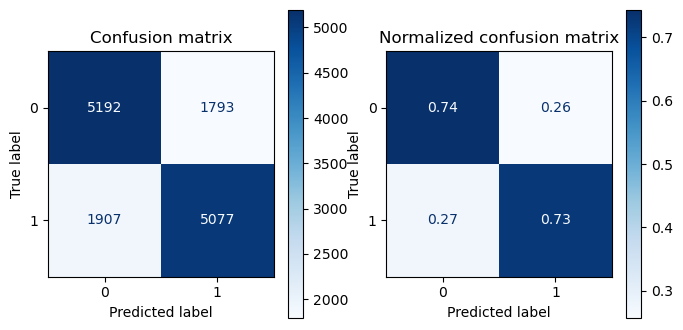

In [58]:
custom_proba = proba[:, 1].reshape(-1, 1)
binarizer = Binarizer(threshold=threshold).fit(custom_proba)
custom_prediction = binarizer.transform(custom_proba)

get_evaluation(y_test, custom_prediction, lg, X_test)

In [64]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold

kfold = KFold(n_splits=10, shuffle=True, random_state=124)

X_train, X_test, y_train, y_test = lda_train_df.iloc[:, :-1], lda_test_df.iloc[:, :-1], lda_train_df.iloc[:, -1], lda_test_df.iloc[:, -1]

logistic_r = LogisticRegression(solver='liblinear', penalty='l1', C=1, random_state=124)
score = cross_val_score(logistic_r, X_train, y_train, cv=kfold, scoring='accuracy')

print(score)
print(f'교차 검증 시 평균 정확도: {np.round(np.mean(score), 4)}')

[0.74212598 0.74481031 0.72244094 0.73783107 0.7300877  0.72525506
 0.74118489 0.73706819 0.74923931 0.74172185]
교차 검증 시 평균 정확도: 0.7372


In [65]:
logistic_r.fit(X_train, y_train)
prediction = logistic_r.predict(X_test)
print(f'테스트 데이터에 대한 실제 예측 정확도: {np.round(accuracy_score(y_test , prediction), 4)}')

테스트 데이터에 대한 실제 예측 정확도: 0.7351


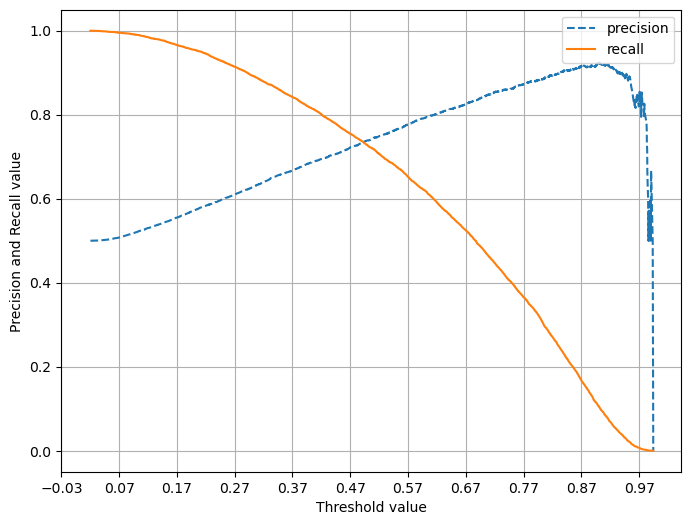

In [61]:
import numpy as np

precision_recall_curve_plot(y_test, lg.predict_proba(X_test)[:, 1].reshape(-1, 1))

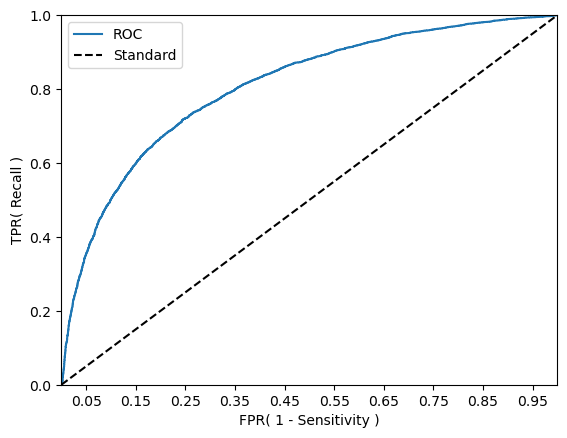

In [63]:
roc_curve_plot(y_test, lg.predict_proba(X_test)[:, 1].reshape(-1, 1))